<a href="https://colab.research.google.com/github/SimeonHristov99/ML_21-22/blob/main/Week_05_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing:
  
1. Drop columns that:
  - are a function of the label
  - have low variance (they give little information)
  - are numeric but have less than 5 unique values
  - are categorical with 1 unique value
  - are categorical with >= 1000 unique values (high-cardinality column) that cannot be encoded

2. Missing values:
  - Remove if:
    - the missing values are labels
    - missing values in column > 20%
  - Impute if:
    - categorical:
      - impute with mode
      - impute with new category (if they are equal to or more than the valid samples or if it means something)
    - numeric:
      - impute with mode
      - knn imputation (if samples >= 3000) (use as a last resort)

3. Feature transformations:
  - categorical:
    - OneHotEncoder
  - numeric:
    - if skewness >= 0.5: log transform once using np.log1p (adds 1 so as to avoid log(0))
    - if cyclical: cosine transformation (eg. month: 0 and 11 will be close, but 5 will be on the polar end)
    - Goal: make them normally distributed in order to help models perform better.

4. Scaling:
  - **make sure there are no columns with 1 value**
  - generally we scale values so that they have mean of 0 and standard deviation of 1


# Analyzing Supply Chain Data
 - Data: https://www.kaggle.com/datasets/abdelrahmancae/supply-chain-analysis-and-modeling
 - Type of problem: Multiclass classification.
 - Goal: Predict the shipment mode.

## Imports and Constants

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [167]:
FIG_SIZE = (20, 15)
plt.rc('figure', figsize=FIG_SIZE)

## Get data

In [168]:
!wget https://raw.githubusercontent.com/SimeonHristov99/ML_21-22/main/Week_05%20-%20Data%20Preprocessing/SCMS_Delivery_History_Dataset.csv

--2022-03-24 14:56:46--  https://raw.githubusercontent.com/SimeonHristov99/ML_21-22/main/Week_05%20-%20Data%20Preprocessing/SCMS_Delivery_History_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3785904 (3.6M) [text/plain]
Saving to: ‘SCMS_Delivery_History_Dataset.csv.2’

SCMS_Delivery_Histo 100%[===================>]   3.61M  --.-KB/s    in 0.07s   

2022-03-24 14:56:47 (54.0 MB/s) - ‘SCMS_Delivery_History_Dataset.csv.2’ saved [3785904/3785904]



## Exploratory Data Analysis

In [169]:
df = pd.read_csv('/content/SCMS_Delivery_History_Dataset.csv')
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,1138

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [171]:
df.describe()

,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


In [172]:
df.isna().mean().sort_values(ascending=False)

Dosage                          0.168152
Shipment Mode                   0.034870
Line Item Insurance (USD)       0.027799
Molecule/Test Type              0.000000
Brand                           0.000000
Dosage Form                     0.000000
Unit of Measure (Per Pack)      0.000000
Line Item Quantity              0.000000
Line Item Value                 0.000000
Vendor                          0.000000
Pack Price                      0.000000
Unit Price                      0.000000
Manufacturing Site              0.000000
First Line Designation          0.000000
Weight (Kilograms)              0.000000
Freight Cost (USD)              0.000000
Item Description                0.000000
ID                              0.000000
Project Code                    0.000000
Product Group                   0.000000
Delivery Recorded Date          0.000000
Delivered to Client Date        0.000000
Scheduled Delivery Date         0.000000
PO Sent to Vendor Date          0.000000
PQ First Sent to

In [173]:
df[df['Shipment Mode'].isna()].index

Int64Index([  16,   31,   36,   42,   50,  157,  158,  165,  186,  187,
            ...
            2526, 2527, 2528, 2529, 2530, 2539, 2552, 2561, 2574, 2610],
           dtype='int64', length=360)

In [174]:
df.drop(df[df['Shipment Mode'].isna()].index, axis=0).isna().mean()

ID                              0.000000
Project Code                    0.000000
PQ #                            0.000000
PO / SO #                       0.000000
ASN/DN #                        0.000000
Country                         0.000000
Managed By                      0.000000
Fulfill Via                     0.000000
Vendor INCO Term                0.000000
Shipment Mode                   0.000000
PQ First Sent to Client Date    0.000000
PO Sent to Vendor Date          0.000000
Scheduled Delivery Date         0.000000
Delivered to Client Date        0.000000
Delivery Recorded Date          0.000000
Product Group                   0.000000
Sub Classification              0.000000
Vendor                          0.000000
Item Description                0.000000
Molecule/Test Type              0.000000
Brand                           0.000000
Dosage                          0.169109
Dosage Form                     0.000000
Unit of Measure (Per Pack)      0.000000
Line Item Quanti

In [175]:
df['Shipment Mode'].value_counts(normalize=True)

Air            0.613509
Truck          0.284022
Air Charter    0.065235
Ocean          0.037234
Name: Shipment Mode, dtype: float64

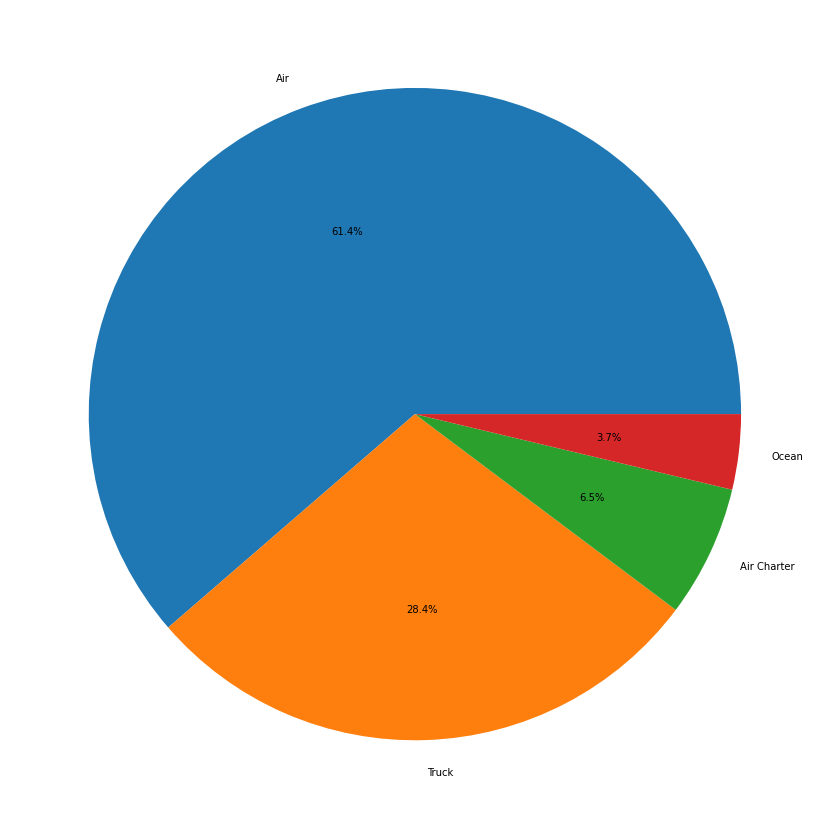

In [176]:
plt.pie(
    df['Shipment Mode'].value_counts(normalize=True).values,
    labels=df['Shipment Mode'].value_counts(normalize=True).index,
    autopct='%1.1f%%',
)
plt.show()

In [177]:
df['Dosage'].value_counts(normalize=True)

300mg              0.115277
200mg              0.108524
600mg              0.089893
150/300mg          0.069865
150/300/200mg      0.067536
10mg/ml            0.064276
150mg              0.050186
200/50mg           0.045994
300/300mg          0.035049
600/300/300mg      0.033302
150/200/30mg       0.029110
100mg              0.026549
50mg               0.020261
200/300mg          0.018631
80/20mg/ml         0.018398
400mg              0.018165
20mg/ml            0.017699
30mg               0.016768
600/200/300mg      0.016185
150/30mg           0.015487
30/50/60mg         0.014788
300/200mg          0.010946
30/60mg            0.010363
250mg              0.010247
60/30mg            0.008500
100/25mg           0.008500
600/300mg          0.007336
300/100mg          0.006288
1mg/ml             0.006288
20mg               0.005007
25mg               0.004541
15mg               0.004425
30mg/ml            0.003843
300/150/300mg      0.003260
30/50/6mg          0.002212
30/6mg             0

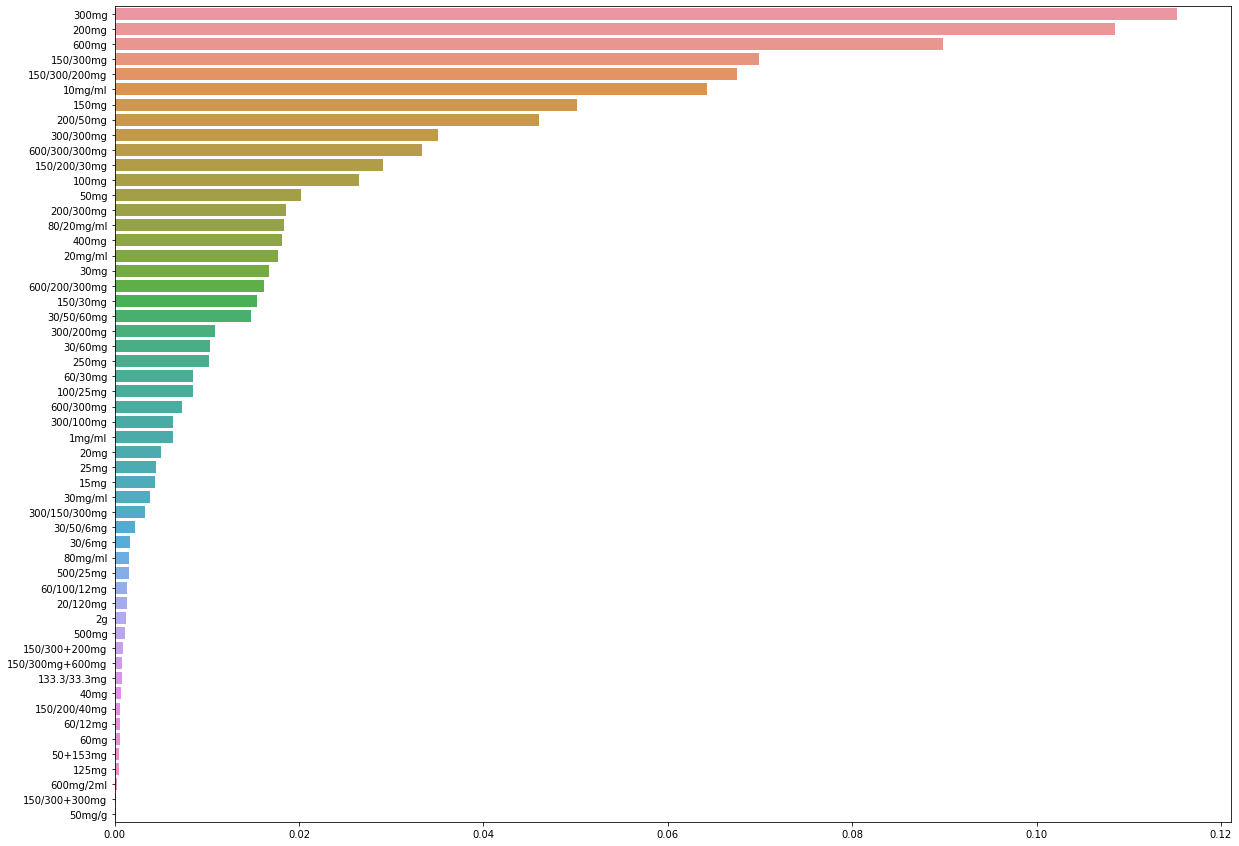

In [178]:
ax = sns.barplot(
    y=df['Dosage'].value_counts(normalize=True).index,
    x=df['Dosage'].value_counts(normalize=True).values,
)


In [179]:
df['Dosage'].mode()[0]

'300mg'

In [180]:
df['Dosage'].fillna(df['Dosage'].mode()[0]).isna().sum()

0

In [181]:
df['Line Item Insurance (USD)']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
10319     705.79
10320     161.71
10321    5284.04
10322     134.03
10323      85.82
Name: Line Item Insurance (USD), Length: 10324, dtype: float64

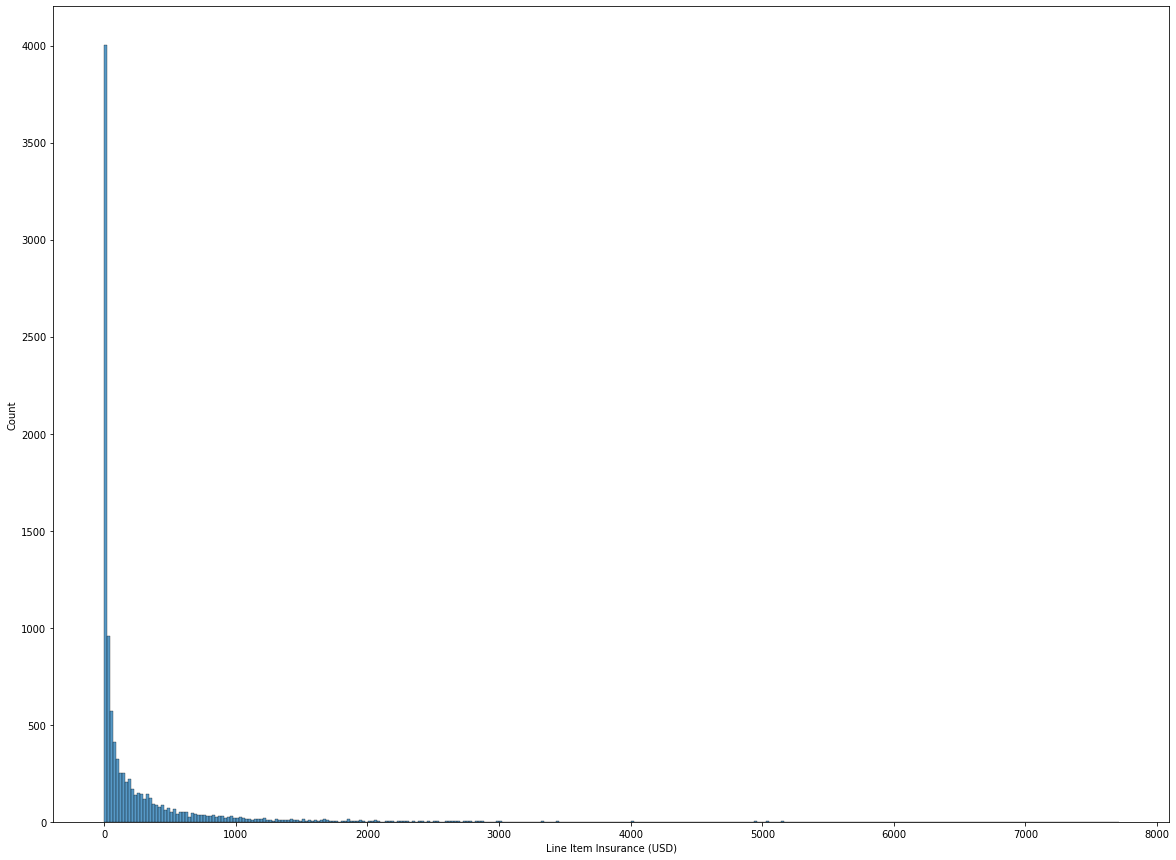

In [182]:
ax = sns.histplot(df['Line Item Insurance (USD)'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


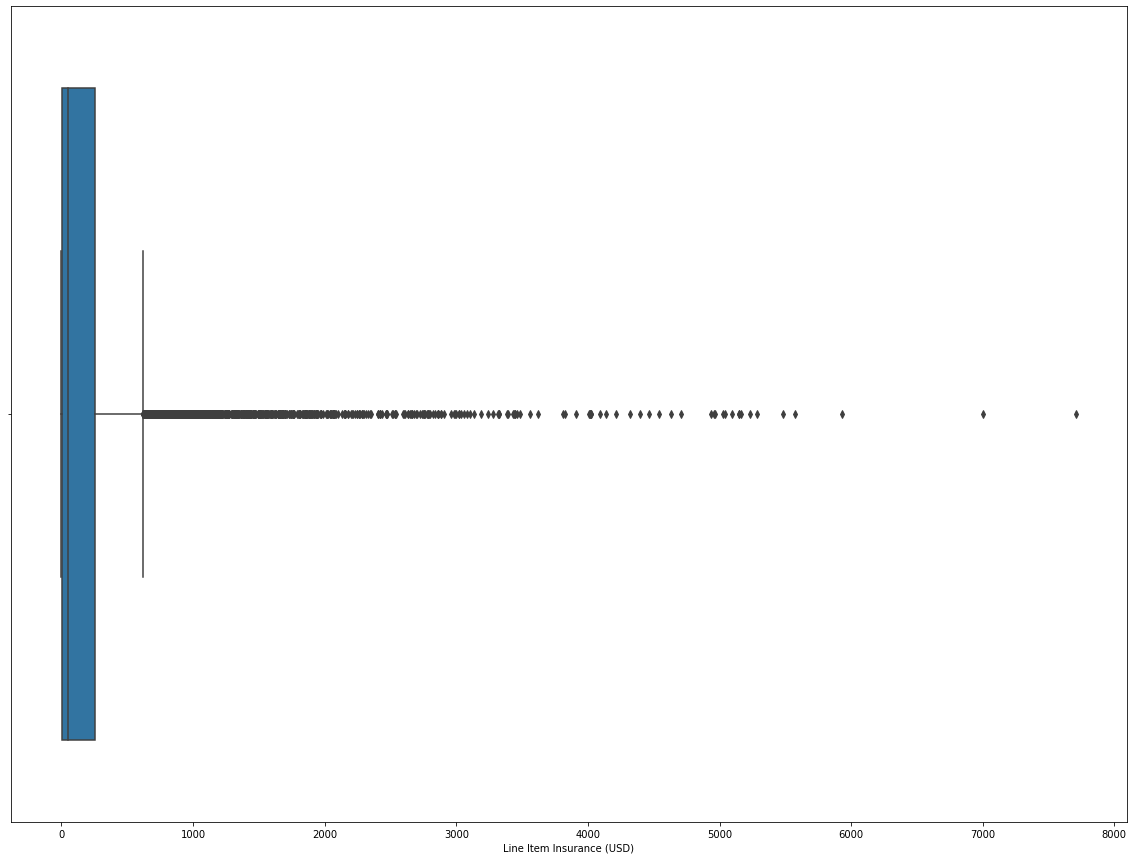

In [183]:
ax = sns.boxplot(df['Line Item Insurance (USD)'])

In [184]:
df['Line Item Insurance (USD)'].mode()[0]

0.0

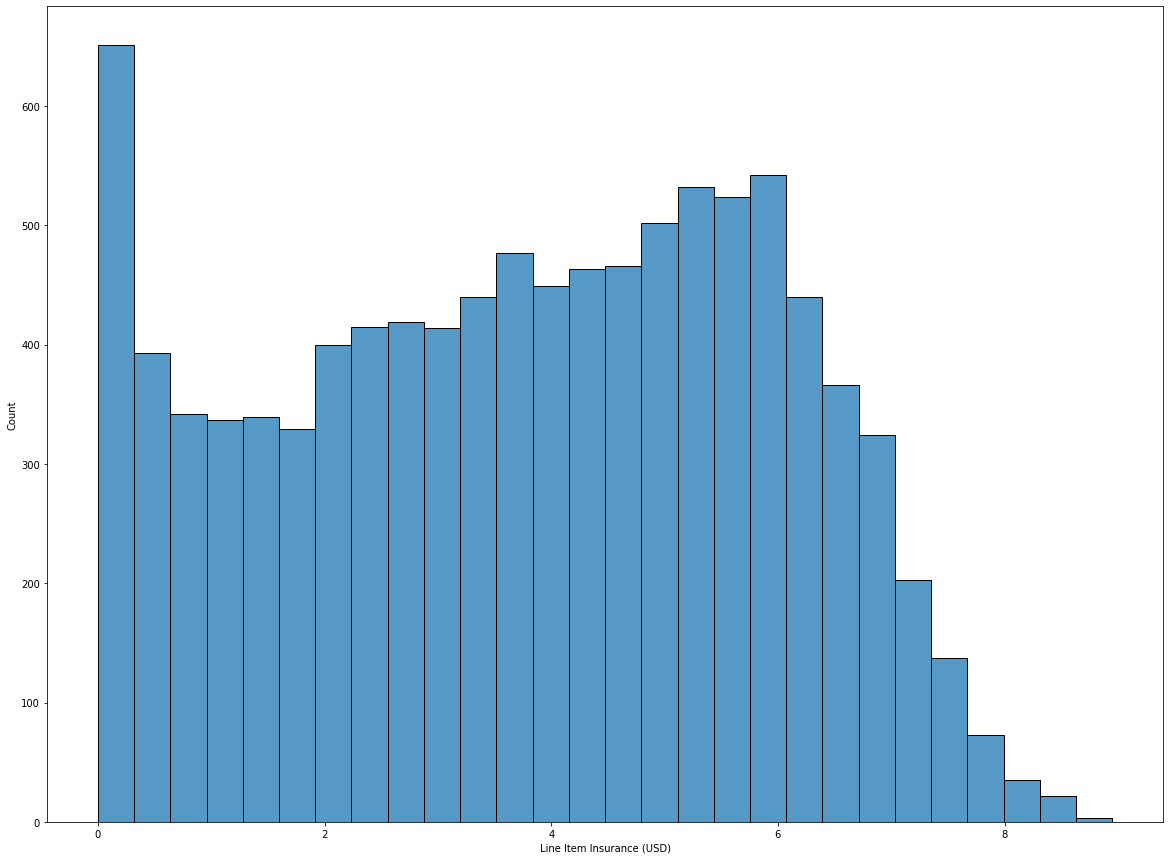

In [185]:
ax = sns.histplot(np.log1p(df['Line Item Insurance (USD)']))

In [186]:
{ col: len(df[col].unique()) for col in df.select_dtypes('number').columns }

{'ID': 10324,
 'Line Item Insurance (USD)': 6723,
 'Line Item Quantity': 5065,
 'Line Item Value': 8741,
 'Pack Price': 1175,
 'Unit Price': 183,
 'Unit of Measure (Per Pack)': 31}

In [187]:
{ col: len(df[col].unique()) for col in df.select_dtypes('object').columns }

{'ASN/DN #': 7030,
 'Brand': 48,
 'Country': 43,
 'Delivered to Client Date': 2093,
 'Delivery Recorded Date': 2042,
 'Dosage': 55,
 'Dosage Form': 17,
 'First Line Designation': 2,
 'Freight Cost (USD)': 6733,
 'Fulfill Via': 2,
 'Item Description': 184,
 'Managed By': 4,
 'Manufacturing Site': 88,
 'Molecule/Test Type': 86,
 'PO / SO #': 6233,
 'PO Sent to Vendor Date': 897,
 'PQ #': 1237,
 'PQ First Sent to Client Date': 765,
 'Product Group': 5,
 'Project Code': 142,
 'Scheduled Delivery Date': 2006,
 'Shipment Mode': 5,
 'Sub Classification': 6,
 'Vendor': 73,
 'Vendor INCO Term': 8,
 'Weight (Kilograms)': 4688}

In [188]:
df['Fulfill Via'].value_counts()

From RDC       5404
Direct Drop    4920
Name: Fulfill Via, dtype: int64

In [189]:
df['Item Description']

0        HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...
1        Nevirapine 10mg/ml, oral suspension, Bottle, 2...
2           HIV 1/2, Determine Complete HIV Kit, 100 Tests
3                       Lamivudine 150mg, tablets, 60 Tabs
4                        Stavudine 30mg, capsules, 60 Caps
                               ...                        
10319    Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...
10320    Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs
10321    Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...
10322    Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs
10323    Lamivudine/Zidovudine 30/60mg, dispersible tab...
Name: Item Description, Length: 10324, dtype: object

In [190]:
df['Molecule/Test Type'].value_counts()

Efavirenz                           1125
Nevirapine                           877
Lamivudine/Nevirapine/Zidovudine     707
Lamivudine/Zidovudine                689
Lopinavir/Ritonavir                  633
                                    ... 
Mefloquine (as hydrochloride)          1
Quinine (as sulfate)                   1
Primaquine base (as diphosphate)       1
Lamivudine/Zidovudine+Abacavir         1
Nelfinavir                             1
Name: Molecule/Test Type, Length: 86, dtype: int64

In [191]:
df['PQ #'].apply(lambda x: x.split(' ')[0].split('-')[0])

0        Pre
1        Pre
2        Pre
3        Pre
4        Pre
        ... 
10319    FPQ
10320    FPQ
10321    FPQ
10322    FPQ
10323    FPQ
Name: PQ #, Length: 10324, dtype: object

In [192]:
df['PO / SO #'].apply(lambda x: x.split(' ')[0].split('-')[0])

0        SCMS
1        SCMS
2        SCMS
3        SCMS
4        SCMS
         ... 
10319      SO
10320      SO
10321      SO
10322      SO
10323      SO
Name: PO / SO #, Length: 10324, dtype: object

In [193]:
df['PO Sent to Vendor Date'].value_counts()

N/A - From RDC       5404
Date Not Captured     328
8/27/14                80
3/19/10                78
8/29/14                76
                     ... 
5/18/15                 1
2/10/14                 1
10/16/13                1
12/9/11                 1
8/29/12                 1
Name: PO Sent to Vendor Date, Length: 897, dtype: int64

In [194]:
df.describe(include=[object])

,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD)
count,10324,10324,10324,10324,10324,10324,10324,10324,9964,10324,10324,10324,10324,10324,10324,10324,10324,10324,10324,10324,8588,10324,10324,10324,10324,10324
unique,142,1237,6233,7030,43,4,2,8,4,765,897,2006,2093,2042,5,6,73,184,86,48,54,17,88,2,4688,6733
top,116-ZA-T30,Pre-PQ Process,SCMS-199289,ASN-19166,South Africa,PMO - US,From RDC,N/A - From RDC,Air,Pre-PQ Process,N/A - From RDC,29-Aug-14,29-Aug-14,29-Aug-14,ARV,Adult,SCMS from RDC,"Efavirenz 600mg, tablets, 30 Tabs",Efavirenz,Generic,300mg,Tablet,"Aurobindo Unit III, India",Yes,Weight Captured Separately,Freight Included in Commodity Cost
freq,768,2681,67,54,1406,10265,5404,5404,6113,2476,5404,97,74,67,8550,6595,5404,755,1125,7285,990,3532,3172,7030,1507,1442


In [195]:
df['ASN/DN #'].apply(lambda x : x.split('-')[0])

0        ASN
1        ASN
2        ASN
3        ASN
4        ASN
        ... 
10319     DN
10320     DN
10321     DN
10322     DN
10323     DN
Name: ASN/DN #, Length: 10324, dtype: object

In [196]:
df['Brand'].value_counts()

Generic            7285
Determine           799
Uni-Gold            373
Aluvia              250
Kaletra             165
Norvir              136
Stat-Pak            115
Bioline             113
Truvada              94
Videx                84
Colloidal Gold       70
Stocrin/Sustiva      69
OraQuick             60
Invirase             53
Viread               52
Zerit                46
Isentress            44
Epivir               42
Prezista             42
Videx EC             41
Retrovir             41
Ziagen               37
Crixivan             36
Capillus             35
Intelence            32
Genie                30
Viramune             28
Clearview            19
Trizivir             18
Reyataz              18
Atripla              16
First Response       15
Coartem              12
Viracept             11
DoubleCheck           5
INSTi                 5
Multispot             5
Paramax               5
LAV                   4
Combivir              3
Reveal                3
ImmunoComb      

In [197]:
df['Freight Cost (USD)'].mode()

0    Freight Included in Commodity Cost
dtype: object

In [198]:
df['Weight (Kilograms)']

0                                13
1                               358
2                               171
3                              1855
4                              7590
                    ...            
10319       See DN-4307 (ID#:83920)
10320       See DN-4313 (ID#:83921)
10321    Weight Captured Separately
10322                          1392
10323    Weight Captured Separately
Name: Weight (Kilograms), Length: 10324, dtype: object

In [199]:
df['Weight (Kilograms)'].mode()

0    Weight Captured Separately
dtype: object

In [200]:
df['Project Code'].value_counts()

116-ZA-T30    768
104-CI-T30    729
151-NG-T30    628
114-UG-T30    596
108-VN-T30    522
             ... 
100-SN-T01      1
201-UG-T30      1
100-GN-T30      1
A02-SN-T50      1
104-SZ-T30      1
Name: Project Code, Length: 142, dtype: int64

In [201]:
numerical_features = ['Weight (Kilograms)', 'Freight Cost (USD)']

df['Weight (Kilograms)'].replace({'See ASN-93 (ID#:1281)': '0'})

0                                13
1                               358
2                               171
3                              1855
4                              7590
                    ...            
10319       See DN-4307 (ID#:83920)
10320       See DN-4313 (ID#:83921)
10321    Weight Captured Separately
10322                          1392
10323    Weight Captured Separately
Name: Weight (Kilograms), Length: 10324, dtype: object

In [202]:
df[df['Weight (Kilograms)'].str.isnumeric()]['Weight (Kilograms)'].mode()[0]

'2'

In [203]:
df.loc[~df['Weight (Kilograms)'].str.isnumeric(), ['Weight (Kilograms)']] = df[df['Weight (Kilograms)'].str.isnumeric()]['Weight (Kilograms)'].mode()[0]

In [204]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,2,See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,2,See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,2,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392,Freight Inclu

In [205]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

## Preprocessing

In [224]:
def preprocess_inputs(df):
  df = df.copy()

  # Remove columns that provide litte information.
  df = df.drop(['ID'], axis=1)

  # Remove rows/samples with missing values in the target column.
  # df[df['Shipment Mode'].isna()]
  df = df.drop(df[df['Shipment Mode'].isna()].index, axis=0)

  # Fill in missing values
  df['Dosage'] = df['Dosage'].fillna(df['Dosage'].mode()[0])
  df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].mode()[0])

  # Feture transformations
  df['Line Item Insurance (USD)'] = np.log1p(df['Line Item Insurance (USD)'])

  # Extract year, month and day from date features
  date_features = ['Delivered to Client Date', 'Delivery Recorded Date']

  df = df.drop(['PO Sent to Vendor Date', 'PQ First Sent to Client Date', 'Scheduled Delivery Date'], axis=1)

  for feat in date_features:
    df[f'Year {feat}'] = pd.to_datetime(df[feat]).apply(lambda x: x.year)
    df[f'Month {feat}'] = pd.to_datetime(df[feat]).apply(lambda x: x.month)
    df[f'Day {feat}'] = pd.to_datetime(df[feat]).apply(lambda x: x.day)
    df = df.drop(feat, axis=1)

  df['ASN/DN #'] = df['ASN/DN #'].apply(lambda x : x.split('-')[0])
  df['PQ #'] = df['PQ #'].apply(lambda x: x.split(' ')[0].split('-')[0])
  df['PO / SO #'] = df['PO / SO #'].apply(lambda x: x.split(' ')[0].split('-')[0])

  for col in ['Freight Cost (USD)', 'Weight (Kilograms)']:
    m = df[df[col].str.isnumeric()][col].mode()[0]
    df.loc[~df[col].str.isnumeric(), [col]] = m
    df[col] = df[col].astype(int)

  dummies = pd.get_dummies(X.select_dtypes('object'))

  df = df.drop(X.select_dtypes('object').columns, axis=1)

  return pd.concat([df, dummies], axis=1)

In [225]:
X = preprocess_inputs(df)

In [226]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9964 entries, 0 to 10323
Columns: 783 entries, Unit of Measure (Per Pack) to First Line Designation_Yes
dtypes: float64(4), int64(10), uint8(769)
memory usage: 8.4 MB


In [227]:
X

,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Year Delivered to Client Date,Month Delivered to Client Date,Day Delivered to Client Date,Year Delivery Recorded Date,Month Delivery Recorded Date,Day Delivery Recorded Date,Project Code_100-BJ-T30,Project Code_100-BW-T01,Project Code_100-BZ-T30,Project Code_100-CI-T01,Project Code_100-DO-T30,Project Code_100-GH-T01,Project Code_100-GH-T30,Project Code_100-GN-T30,Project Code_100-HT-T01,Project Code_100-KZ-T01,Project Code_100-LB-T01,Project Code_100-PK-T01,Project Code_100-SL-T01,Project Code_100-SN-T01,Project Code_100-SZ-T01,Project Code_100-ZM-T30,Project Code_100-ZW-T01,Project Code_100-ZW-T30,Project Code_101-AF-T30,Project Code_101-CD-T30,Project Code_101-KE-T30,Project Code_101-ZA-T30,Project Code_102-AO-T30,Project Code_102-BI-T30,Project Code_102-BW-T01,Project Code_102-BW-T30,Project Code_102-CD-T30,Project Code_102-DO-T30,Project Code_102-GY-T01,Project Code_102-GY-T30,Project Code_102-KE-T01,Project Code_102-KE-T30,Project Code_102-LS-T01,Project Code_102-LY-T30,Project Code_102-ML-T30,Project Code_102-MW-T30,Project Code_102-NG-T01,Project Code_102-SD-T30,Project Code_102-SS-T30,Project Code_102-SZ-T30,Project Code_102-UG-T30,Project Code_102-ZW-T30,Project Code_103-AO-T30,Project Code_103-CD-T30,Project Code_103-CM-T30,Project Code_103-DO-T30,Project Code_103-KE-T30,Project Code_103-ML-T30,Project Code_103-MW-T30,Project Code_103-SS-T30,Project Code_103-UG-T30,Project Code_103-ZW-T30,Project Code_104-BW-T30,Project Code_104-CI-T01,Project Code_104-CI-T30,Project Code_104-SZ-T30,Project Code_105-DO-T30,Project Code_105-GH-T30,Project Code_105-GY-T01,Project Code_105-GY-T30,Project Code_105-SS-T30,Project Code_106-HT-T01,Project Code_106-HT-T30,Project Code_107-RW-T01,Project Code_107-RW-T30,Project Code_108-VN-T01,Project Code_108-VN-T30,Project Code_109-TZ-T01,Project Code_109-TZ-T30,Project Code_110-PK-T30,Project Code_110-ZM-T01,Project Code_110-ZM-T30,Project Code_111-MZ-T01,Project Code_111-MZ-T30,Project Code_112-NG-T01,Project Code_112-NG-T30,Project Code_113-ZW-T01,Project Code_113-ZW-T30,Project Code_114-UG-T01,Project Code_114-UG-T30,Project Code_116-ZA-T01,Project Code_116-ZA-T30,Project Code_117-ET-T01,Project Code_117-ET-T30,Project Code_119-NA-T01,Project Code_119-NA-T30,Project Code_120-AO-T01,Project Code_122-HT-T30,Project Code_123-NG-T01,Project Code_123-NG-T30,Project Code_125-HT-T01,Project Code_126-NG-T01,Project Code_127-KE-T01,Project Code_127-KE-T30,Project Code_128-BJ-T01,Project Code_129-KG-T01,Project Code_130-NG-T01,Project Code_131-NG-T01,Project Code_132-NG-T01,Project Code_133-NG-T01,Project Code_133-NG-T30,Project Code_136-RW-T01,Project Code_139-NA-T01,Project Code_141-NA-T01,Project Code_144-BW-T01,Project Code_144-BW-T30,Project Code_151-NG-T01,Project Code_151-NG-T30,Project Code_152-HT-T30,Project Code_153-NA-T30,Project Code_153-NG-T01,Project Code_154-NG-T30,Project Code_161-ZA-T30,Project Code_200-DO-T30,Project Code_200-UG-T30,Project Code_200-ZW-T30,Project Code_201-UG-T30,Project Code_202-GT-T30,Project Code_203-SZ-T30,Project Code_510-KE-T01,Project Code_800-CM-T30,Project Code_800-LS-T30,Project Code_900-CM-T30,Project Code_900-GH-T30,Project Code_900-GY-T30,Project Code_900-LR-T30,Project Code_900-SS-T30,Project Code_900-SZ-T30,Project Code_900-TG-T30,Project Code_900-TZ-T30,Project Code_900-UG-T30,Project Code_901-CM-T30,Project Code_901-GH-T30,Project Code_901-LR-T30,Project Code_901-NA-T30,Project Code_901-SZ-T30,Project Code_A01-BF-T50,Project Code_A01-CM-T50,Project Code_A01-SN-T50,Project Code_A01-ZM-T50,Project Code_A02-SL-T50,Project Code_A02-SN-T50,PQ #_FPQ,PQ #_Pre,PO / SO #_DSCM,PO / SO #_SCMS,PO / SO #_SO,ASN/DN #_ASN,ASN/DN #_DN,Country_Afghanistan,Country_Angola,Country_Belize,Country_Benin,Country_Botswana,Country_Burkina Faso,Country_Burundi,Country_Cameroon,"Country_Congo, DRC",Country_Côte d'Ivoire,Count

In [228]:
X.describe()

,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Year Delivered to Client Date,Month Delivered to Client Date,Day Delivered to Client Date,Year Delivery Recorded Date,Month Delivery Recorded Date,Day Delivery Recorded Date,Project Code_100-BJ-T30,Project Code_100-BW-T01,Project Code_100-BZ-T30,Project Code_100-CI-T01,Project Code_100-DO-T30,Project Code_100-GH-T01,Project Code_100-GH-T30,Project Code_100-GN-T30,Project Code_100-HT-T01,Project Code_100-KZ-T01,Project Code_100-LB-T01,Project Code_100-PK-T01,Project Code_100-SL-T01,Project Code_100-SN-T01,Project Code_100-SZ-T01,Project Code_100-ZM-T30,Project Code_100-ZW-T01,Project Code_100-ZW-T30,Project Code_101-AF-T30,Project Code_101-CD-T30,Project Code_101-KE-T30,Project Code_101-ZA-T30,Project Code_102-AO-T30,Project Code_102-BI-T30,Project Code_102-BW-T01,Project Code_102-BW-T30,Project Code_102-CD-T30,Project Code_102-DO-T30,Project Code_102-GY-T01,Project Code_102-GY-T30,Project Code_102-KE-T01,Project Code_102-KE-T30,Project Code_102-LS-T01,Project Code_102-LY-T30,Project Code_102-ML-T30,Project Code_102-MW-T30,Project Code_102-NG-T01,Project Code_102-SD-T30,Project Code_102-SS-T30,Project Code_102-SZ-T30,Project Code_102-UG-T30,Project Code_102-ZW-T30,Project Code_103-AO-T30,Project Code_103-CD-T30,Project Code_103-CM-T30,Project Code_103-DO-T30,Project Code_103-KE-T30,Project Code_103-ML-T30,Project Code_103-MW-T30,Project Code_103-SS-T30,Project Code_103-UG-T30,Project Code_103-ZW-T30,Project Code_104-BW-T30,Project Code_104-CI-T01,Project Code_104-CI-T30,Project Code_104-SZ-T30,Project Code_105-DO-T30,Project Code_105-GH-T30,Project Code_105-GY-T01,Project Code_105-GY-T30,Project Code_105-SS-T30,Project Code_106-HT-T01,Project Code_106-HT-T30,Project Code_107-RW-T01,Project Code_107-RW-T30,Project Code_108-VN-T01,Project Code_108-VN-T30,Project Code_109-TZ-T01,Project Code_109-TZ-T30,Project Code_110-PK-T30,Project Code_110-ZM-T01,Project Code_110-ZM-T30,Project Code_111-MZ-T01,Project Code_111-MZ-T30,Project Code_112-NG-T01,Project Code_112-NG-T30,Project Code_113-ZW-T01,Project Code_113-ZW-T30,Project Code_114-UG-T01,Project Code_114-UG-T30,Project Code_116-ZA-T01,Project Code_116-ZA-T30,Project Code_117-ET-T01,Project Code_117-ET-T30,Project Code_119-NA-T01,Project Code_119-NA-T30,Project Code_120-AO-T01,Project Code_122-HT-T30,Project Code_123-NG-T01,Project Code_123-NG-T30,Project Code_125-HT-T01,Project Code_126-NG-T01,Project Code_127-KE-T01,Project Code_127-KE-T30,Project Code_128-BJ-T01,Project Code_129-KG-T01,Project Code_130-NG-T01,Project Code_131-NG-T01,Project Code_132-NG-T01,Project Code_133-NG-T01,Project Code_133-NG-T30,Project Code_136-RW-T01,Project Code_139-NA-T01,Project Code_141-NA-T01,Project Code_144-BW-T01,Project Code_144-BW-T30,Project Code_151-NG-T01,Project Code_151-NG-T30,Project Code_152-HT-T30,Project Code_153-NA-T30,Project Code_153-NG-T01,Project Code_154-NG-T30,Project Code_161-ZA-T30,Project Code_200-DO-T30,Project Code_200-UG-T30,Project Code_200-ZW-T30,Project Code_201-UG-T30,Project Code_202-GT-T30,Project Code_203-SZ-T30,Project Code_510-KE-T01,Project Code_800-CM-T30,Project Code_800-LS-T30,Project Code_900-CM-T30,Project Code_900-GH-T30,Project Code_900-GY-T30,Project Code_900-LR-T30,Project Code_900-SS-T30,Project Code_900-SZ-T30,Project Code_900-TG-T30,Project Code_900-TZ-T30,Project Code_900-UG-T30,Project Code_901-CM-T30,Project Code_901-GH-T30,Project Code_901-LR-T30,Project Code_901-NA-T30,Project Code_901-SZ-T30,Project Code_A01-BF-T50,Project Code_A01-CM-T50,Project Code_A01-SN-T50,Project Code_A01-ZM-T50,Project Code_A02-SL-T50,Project Code_A02-SN-T50,PQ #_FPQ,PQ #_Pre,PO / SO #_DSCM,PO / SO #_SCMS,PO / SO #_SO,ASN/DN #_ASN,ASN/DN #_DN,Country_Afghanistan,Country_Angola,Country_Belize,Country_Benin,Country_Botswana,Country_Burkina Faso,Country_Burundi,Country_Cameroon,"Country_Congo, DRC",Country_Côte d'Ivoire,Count

In [230]:
X.isna().sum().sum()

0

# For Home

Kaggle is a repository with datasets for all kinds of machine learning and data science problems.

Take a look at the [Titanic Challenge](https://www.kaggle.com/competitions/titanic/overview). Try to preprocess the data as we did in class. You can create an account if you want to get the dataset and participate in the challenge. If you don't want to create an account, grab the dataset from [our GitHub repo](https://github.com/SimeonHristov99/ML_21-22/tree/main/Week_05%20-%20Data%20Preprocessing).